In [1]:
#imports
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind, ttest_rel

In [2]:
#load in dataframes
#assuming files are local to notebook
df_female_lightActStats_mean = ""
df_female_lightnREM_pct = ""
df_female_lightnREMBout_meannREMB = ""
df_female_lightREM_pct = ""
df_female_lightREMBout_meanREMB = ""
df_female_lightWake_pct = ""
df_female_lightWakeBout_meanWB = pd.read_csv("9_5_25_Thyme_Cohort_1_females_lightWakeBout_meanWB.csv", skiprows=1)

df_male_lightActStats_mean = ""
df_male_lightnREM_pct = ""
df_male_lightnREMBout_meannREMB = ""
df_male_lightREM_pct = ""
df_male_lightREMBout_meanREMB = ""
df_male_lightWake_pct = ""
df_male_lightWakeBout_meanWB = pd.read_csv("9_5_25_Thyme_Cohort_1_males_lightWakeBout_meanWB.csv", skiprows=1)

In [3]:
#declare the names of columns in the treatment groups
treatment_males = ["M5", "M6", "M7", "M8"]
control_males   = ["M1", "M2", "M3", "M4"]

treatment_females = ["F5", "F6", "F7", "F8"]
control_females   = ["F1", "F2", "F3", "F4"]

all_treatment = treatment_males + treatment_females
all_control   = control_males + control_females

In [4]:
#declare treatment time
#ensure double digit times
treatment_time = pd.Timestamp("2025-09-07 08:00")

/home/ari.ginsparg-umw/.local/lib/python3.11/site-packages/pandas/core/indexes/base.py:7588: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)
/home/ari.ginsparg-umw/.local/lib/python3.11/site-packages/pandas/core/indexes/base.py:7588: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)


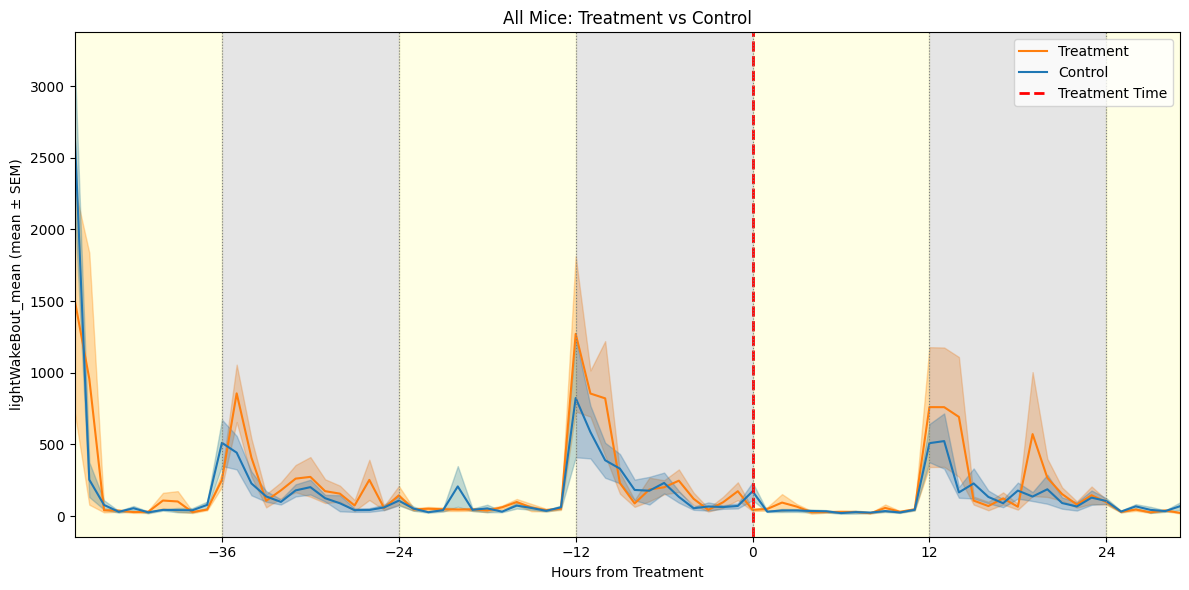

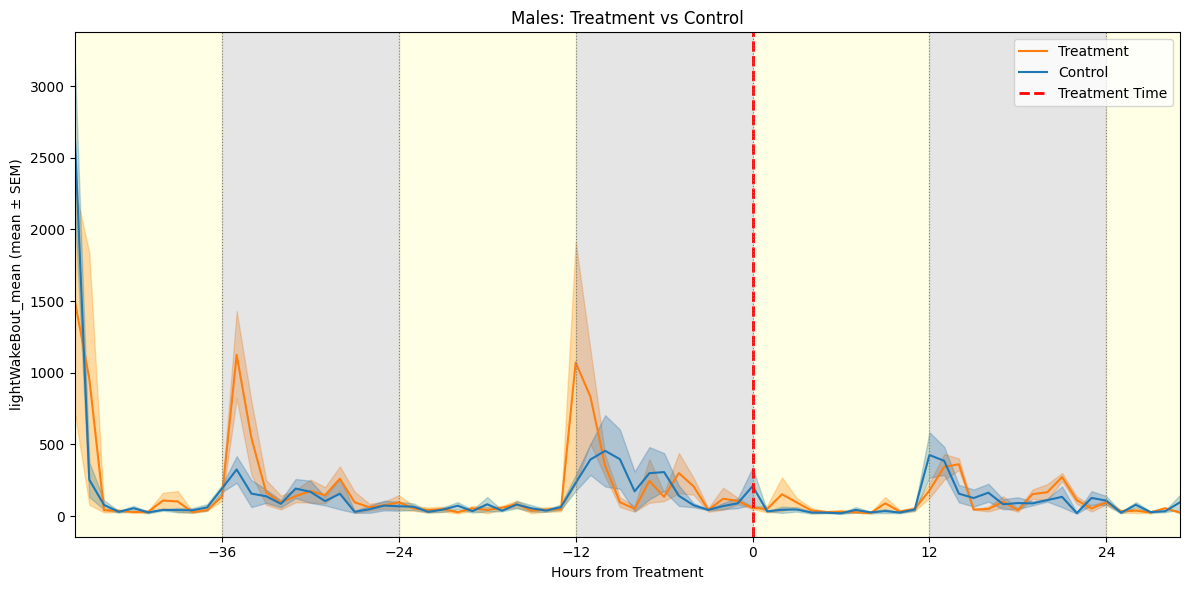

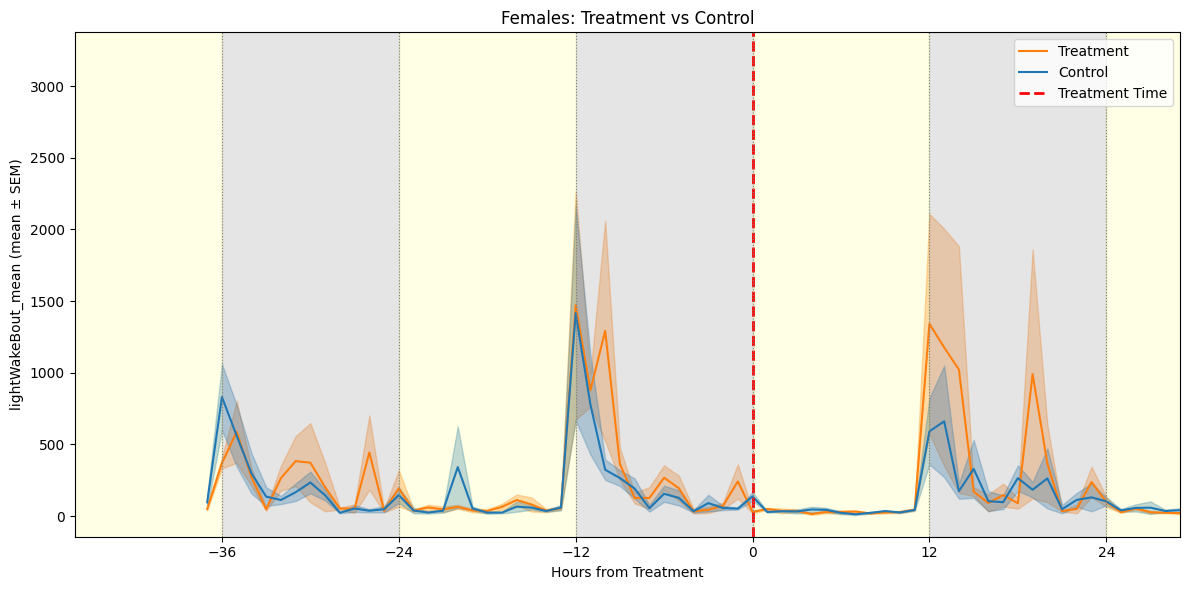

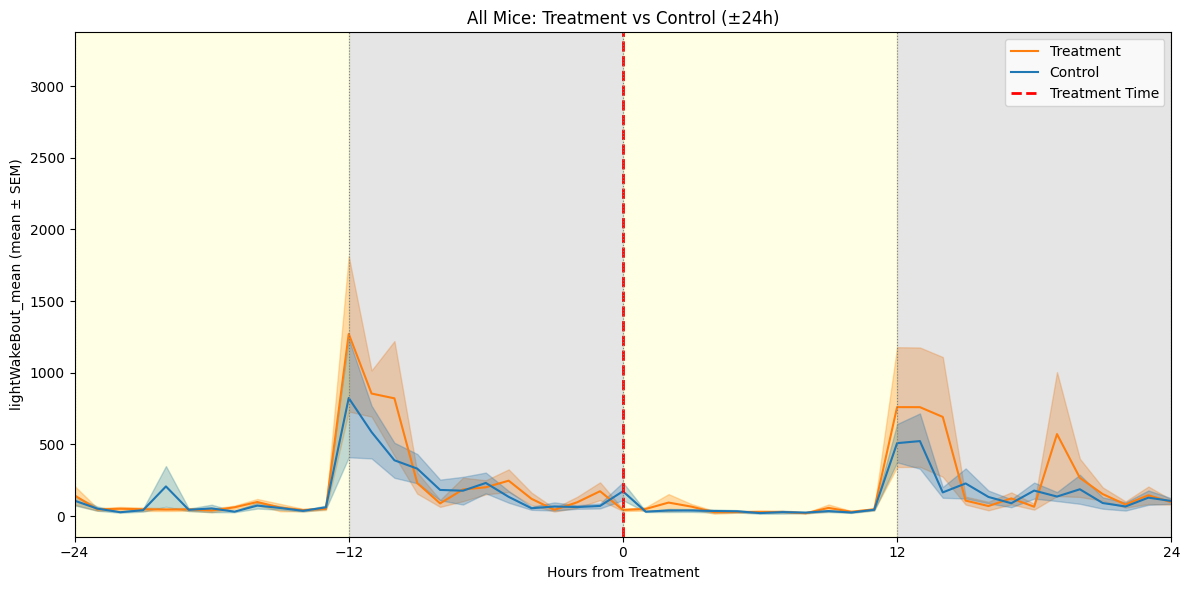

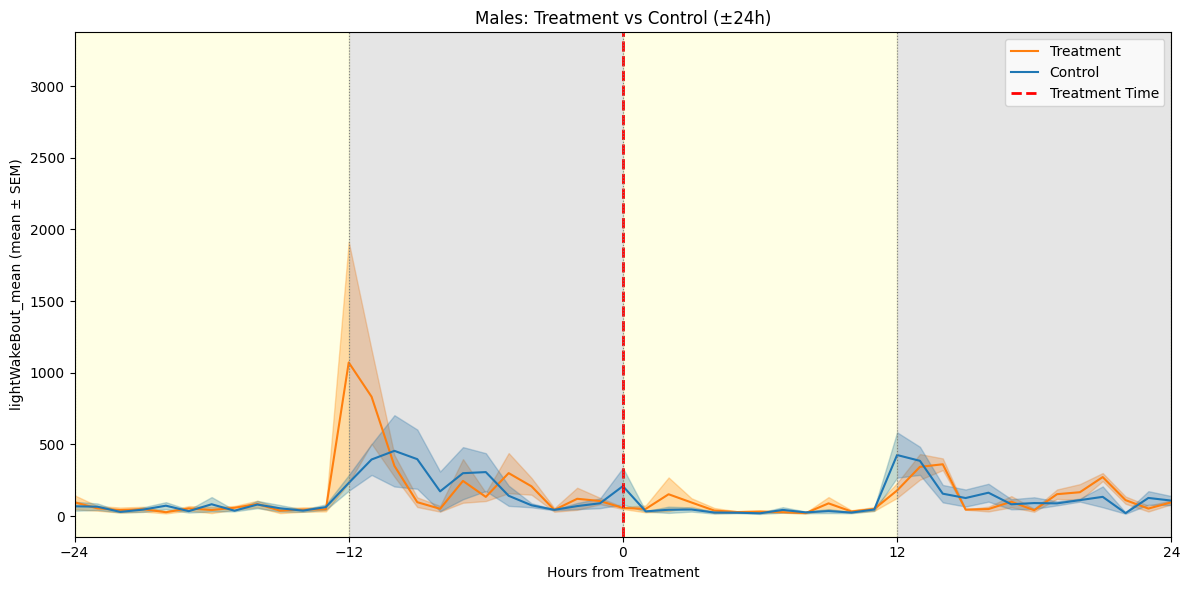

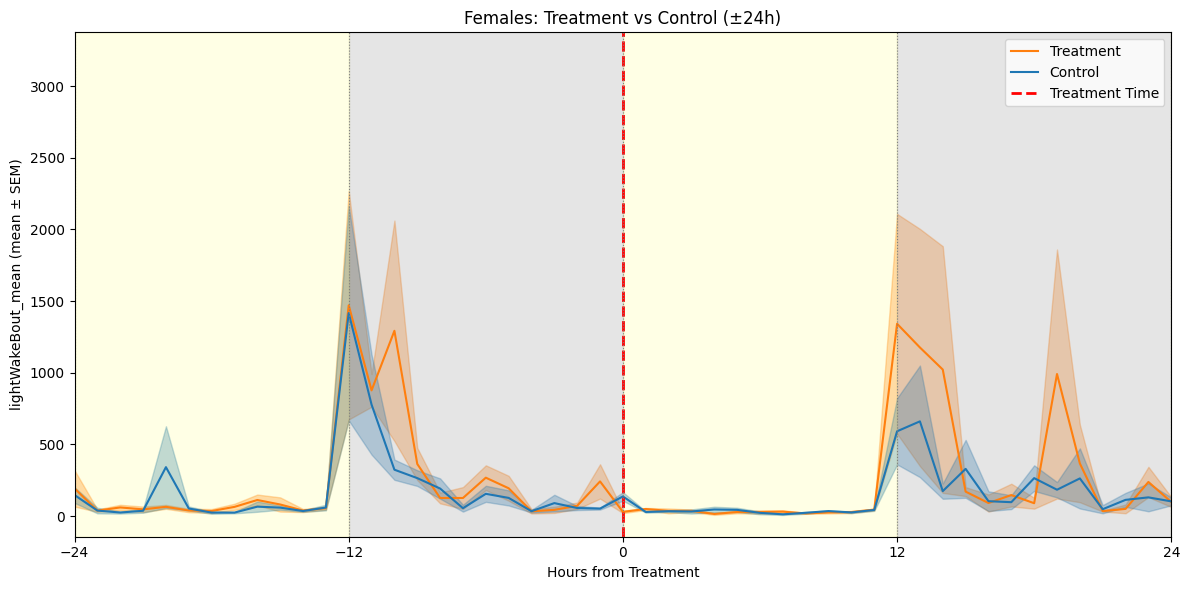

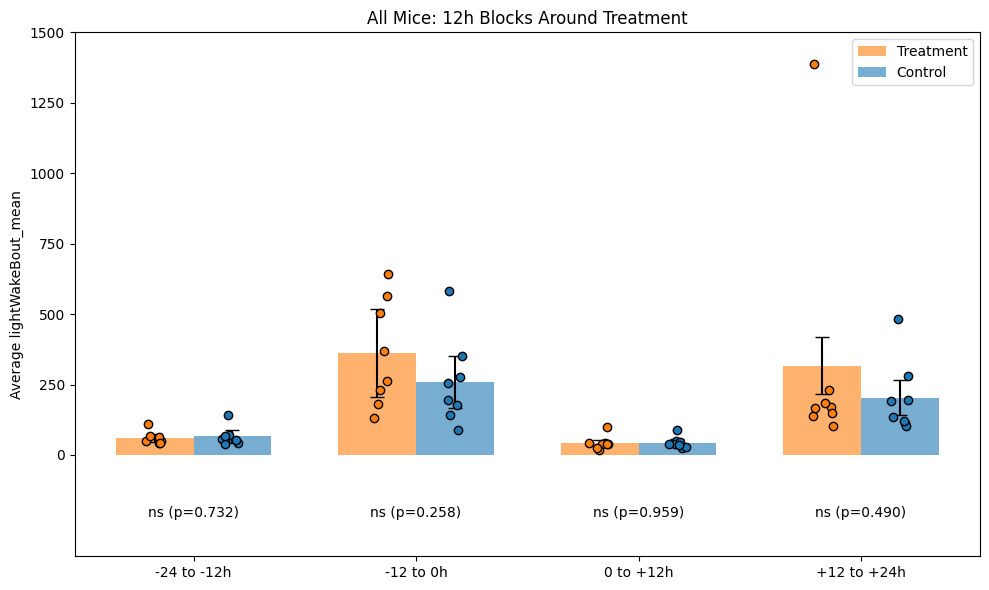

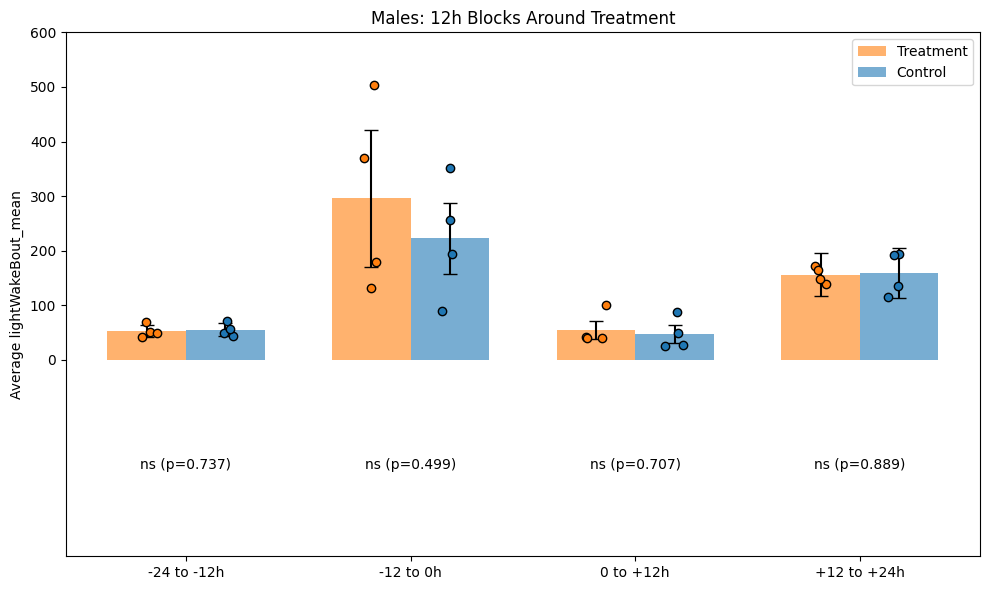

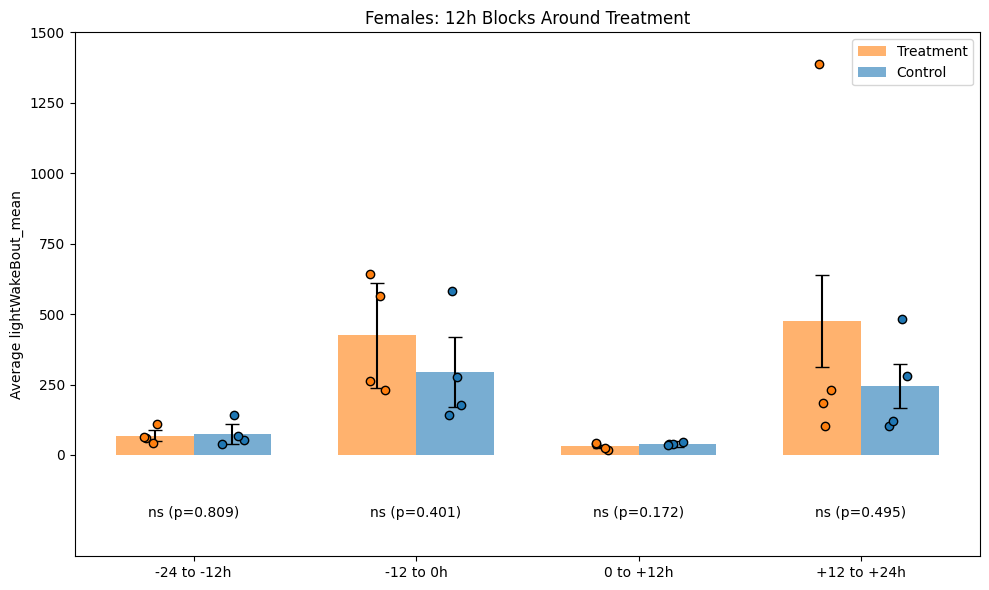

In [5]:
# --- Drop "Linear Time" if present ---
for df in [df_female_lightWakeBout_meanWB, df_male_lightWakeBout_meanWB]:
    if "Linear Time:" in df.columns:
        df.drop(columns=["Linear Time:"], inplace=True)
        
# --- Ensure timestamp is parsed as datetime and set as index ---
for df in [df_female_lightWakeBout_meanWB, df_male_lightWakeBout_meanWB]:
    df.iloc[:, 0] = pd.to_datetime(df.iloc[:, 0])  # first col = timestamp
    df.set_index(df.columns[0], inplace=True)
    
# --- Merge on timestamps, outer join to keep all unique times ---
merged_df = pd.merge(df_female_lightWakeBout_meanWB, df_male_lightWakeBout_meanWB, 
                     how="outer", left_index=True, right_index=True)

# --- Drop rows where the index is NaT ---
merged_df = merged_df[~merged_df.index.isna()]

# --- Sort by timestamp ---
merged_df.sort_index(inplace=True)

# --- Convert to relative hours from treatment time ---
elapsed_hours = (merged_df.index - treatment_time).total_seconds() / 3600.0
merged_df.index = elapsed_hours
merged_df.index.name = "Hours_from_Treatment"

# --- Helper function to get min/max across selected columns --- 
def get_yaxis_limits(df, treatment_cols, control_cols, pad=0.05):
    treat_mean = df[treatment_cols].mean(axis=1)
    treat_sem  = df[treatment_cols].sem(axis=1)
    ctrl_mean = df[control_cols].mean(axis=1)
    ctrl_sem  = df[control_cols].sem(axis=1)
    
    ymin = min((treat_mean - treat_sem).min(), (ctrl_mean - ctrl_sem).min())
    ymax = max((treat_mean + treat_sem).max(), (ctrl_mean + ctrl_sem).max())
    
    ypad = (ymax - ymin) * pad
    return ymin - ypad, ymax + ypad

# --- Compute y-axis limits from "All Mice" ---
ymin, ymax = get_yaxis_limits(merged_df, all_treatment, all_control)

# --- Updated plot_group function compatible with elapsed hours ---
def plot_group(df, treatment_cols, control_cols, title, treatment_time_hours, ylim=None):
    """
    Plot treatment vs control with mean ± SEM, light/dark shading, 
    12-hour markers, and standardized y-axis limits.
    
    Parameters:
        df: DataFrame with elapsed hours as index
        treatment_cols: list of columns for treatment group
        control_cols: list of columns for control group
        title: plot title
        treatment_time_hours: float, hours from treatment (0 at treatment)
        ylim: tuple (ymin, ymax) for standardized y-axis
    """
    plt.figure(figsize=(12, 6))

    # --- Treatment group ---
    treat_mean = df[treatment_cols].mean(axis=1)
    treat_sem  = df[treatment_cols].sem(axis=1)
    plt.plot(df.index, treat_mean, label="Treatment", color="tab:orange")
    plt.fill_between(df.index, treat_mean - treat_sem, treat_mean + treat_sem,
                     color="tab:orange", alpha=0.3)

    # --- Control group ---
    ctrl_mean = df[control_cols].mean(axis=1)
    ctrl_sem  = df[control_cols].sem(axis=1)
    plt.plot(df.index, ctrl_mean, label="Control", color="tab:blue")
    plt.fill_between(df.index, ctrl_mean - ctrl_sem, ctrl_mean + ctrl_sem,
                     color="tab:blue", alpha=0.3)

    # --- Treatment time ---
    plt.axvline(treatment_time_hours, color="red", linestyle="--", linewidth=2, label="Treatment Time")

    # --- Alternate light/dark shading (clipped to data range) ---
    start, end = df.index.min(), df.index.max()
    block_start = start - (start % 12)  # align to nearest 12h
    t = block_start
    is_light = True  # first block = light

    while t <= end:
        block_end = t + 12
        # Clip the shading to data range
        shade_start = max(t, start)
        shade_end   = min(block_end, end)
        color = 'yellow' if is_light else 'gray'
        alpha = 0.1 if is_light else 0.2
        plt.axvspan(shade_start, shade_end, color=color, alpha=alpha)
        t += 12
        is_light = not is_light

    # --- 12h vertical cycle markers ---
    marks = []
    t = treatment_time_hours
    while t >= start:
        marks.append(t)
        t -= 12
    t = treatment_time_hours + 12
    while t <= end:
        marks.append(t)
        t += 12
    marks = sorted(marks)
    for h in marks:
        plt.axvline(h, color="gray", linestyle=":", linewidth=0.8)

    # --- X-axis ticks every 12 hours ---
    xticks = list(range(int(start // 12) * 12, int(end) + 12, 12))
    plt.xticks(xticks)

    # --- Labels & formatting ---
    plt.title(title)
    plt.xlabel("Hours from Treatment")
    plt.ylabel("lightWakeBout_mean (mean ± SEM)")
    plt.legend()
    
    if ylim is not None:
        plt.ylim(ylim)

    # --- Fit x-axis exactly to data ---
    plt.xlim(start, end)
    
    plt.tight_layout()
    plt.show()



# --- Convert treatment_time to hours relative to itself ---
treatment_time_hours = 0  # t=0 at treatment

# --- Run plots with standardized y-axis ---
plot_group(merged_df, all_treatment, all_control, "All Mice: Treatment vs Control", treatment_time_hours, ylim=(ymin, ymax))
plot_group(merged_df, treatment_males, control_males, "Males: Treatment vs Control", treatment_time_hours, ylim=(ymin, ymax))
plot_group(merged_df, treatment_females, control_females, "Females: Treatment vs Control", treatment_time_hours, ylim=(ymin, ymax))

# --- Define the window around treatment (24h before/after) ---
window_start = -24
window_end   = 24

# --- Filter merged_df for the window ---
merged_df_window = merged_df[(merged_df.index >= window_start) & (merged_df.index <= window_end)]

# --- Run the plots for the 3 cases within this window ---
plot_group(merged_df_window, all_treatment, all_control,
           "All Mice: Treatment vs Control (±24h)", treatment_time_hours, ylim=(ymin, ymax))

plot_group(merged_df_window, treatment_males, control_males,
           "Males: Treatment vs Control (±24h)", treatment_time_hours, ylim=(ymin, ymax))

plot_group(merged_df_window, treatment_females, control_females,
           "Females: Treatment vs Control (±24h)", treatment_time_hours, ylim=(ymin, ymax))

import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import ttest_ind, ttest_rel

import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import ttest_ind, ttest_rel

def plot_mouse_bar_4blocks_below_text(df, treatment_cols, control_cols, title, paired=False, sem=True):
    """
    Plot 4 consecutive 12-hour blocks around treatment,
    overlay individual mice, add error bars, show p-values/significance
    directly below y=0, and hide y-axis ticks below 0.
    """
    # Define four 12-hour blocks
    regions = [(-24, -12), (-12, 0), (0, 12), (12, 24)]
    region_labels = ["-24 to -12h", "-12 to 0h", "0 to +12h", "+12 to +24h"]

    # Compute per-mouse means and errors
    treatment_means, control_means = [], []
    treatment_errors, control_errors = [], []

    for start, end in regions:
        t_block = df[treatment_cols][(df.index >= start) & (df.index < end)]
        c_block = df[control_cols][(df.index >= start) & (df.index < end)]
        treatment_means.append(t_block.mean())
        control_means.append(c_block.mean())
        if sem:
            treatment_errors.append(t_block.sem())
            control_errors.append(c_block.sem())
        else:
            treatment_errors.append(t_block.std())
            control_errors.append(c_block.std())

    treatment_means_df = pd.DataFrame(treatment_means).T
    control_means_df   = pd.DataFrame(control_means).T

    x = np.arange(len(region_labels))
    width = 0.35

    fig, ax = plt.subplots(figsize=(10, 6))

    # --- Bars with error bars ---
    ax.bar(x - width/2, [m.mean() for m in treatment_means], width,
           yerr=[e.mean() for e in treatment_errors], color='tab:orange', alpha=0.6, label='Treatment', capsize=5)
    ax.bar(x + width/2, [m.mean() for m in control_means], width,
           yerr=[e.mean() for e in control_errors], color='tab:blue', alpha=0.6, label='Control', capsize=5)

    # --- Overlay individual points ---
    for i in range(len(region_labels)):
        jitter_t = (np.random.rand(len(treatment_cols)) - 0.5) * 0.1
        jitter_c = (np.random.rand(len(control_cols)) - 0.5) * 0.1
        ax.scatter(np.full(len(treatment_cols), x[i] - width/2) + jitter_t,
                   treatment_means_df.iloc[:, i], color='tab:orange', edgecolor='black', zorder=5)
        ax.scatter(np.full(len(control_cols), x[i] + width/2) + jitter_c,
                   control_means_df.iloc[:, i], color='tab:blue', edgecolor='black', zorder=5)

    # --- Compute significance ---
    y_min = min(df[treatment_cols + control_cols].min().min(), 0)
    y_max = df[treatment_cols + control_cols].max().max()
    sig_texts = []
    for i in range(len(region_labels)):
        t_data = treatment_means_df.iloc[:, i].values
        c_data = control_means_df.iloc[:, i].values
        if paired:
            stat, pval = ttest_rel(t_data, c_data)
        else:
            stat, pval = ttest_ind(t_data, c_data)

        if pval < 0.001:
            sig = '***'
        elif pval < 0.01:
            sig = '**'
        elif pval < 0.05:
            sig = '*'
        else:
            sig = 'ns'
        sig_texts.append(f"{sig} (p={pval:.3f})")

    # --- Place significance/p-value below y=0 ---
    y_offset = 0.05 * (y_max - y_min)  # offset below 0
    for i, text in enumerate(sig_texts):
        ax.text(x[i], -y_offset, text, ha='center', va='top', fontsize=10, color='black')

    # --- x-axis ticks/labels ---
    ax.set_xticks(x)
    ax.set_xticklabels(region_labels)
    ax.set_ylabel("Average lightWakeBout_mean")
    ax.set_title(title)
    ax.legend()

    # Extend y-axis slightly to fit text
    ax.set_ylim(bottom=-2*y_offset)

    # --- Hide negative y-axis ticks ---
    yticks = ax.get_yticks()
    ax.set_yticks([t for t in yticks if t >= 0])

    plt.tight_layout()
    plt.show()
    
# All mice
plot_mouse_bar_4blocks_below_text(
    merged_df, 
    all_treatment, 
    all_control, 
    "All Mice: 12h Blocks Around Treatment", 
    paired=False
)

# Males only
plot_mouse_bar_4blocks_below_text(
    merged_df, 
    treatment_males, 
    control_males, 
    "Males: 12h Blocks Around Treatment", 
    paired=False
)

# Females only
plot_mouse_bar_4blocks_below_text(
    merged_df, 
    treatment_females, 
    control_females, 
    "Females: 12h Blocks Around Treatment", 
    paired=False
)
